In [9]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [10]:
path_No = '../Data/no/*'
path_Yes = '../Data/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128)) 
    tumor.append((img, 1))

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

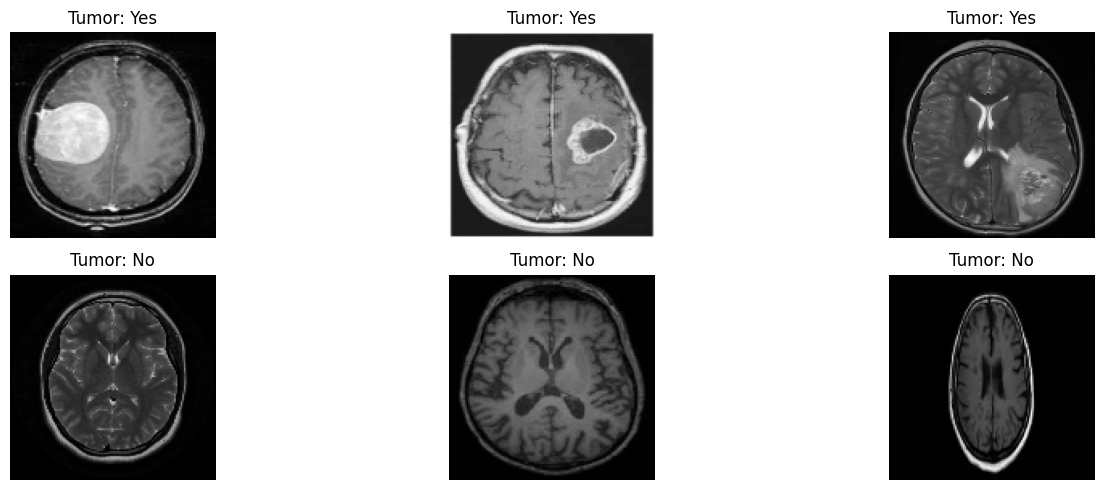

In [11]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

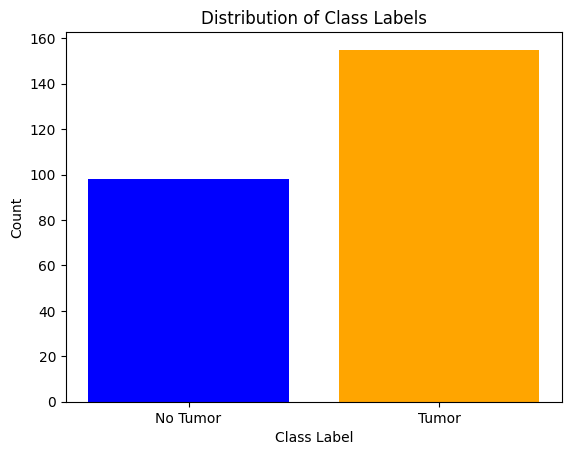

In [12]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [14]:
x_train= x_train /255.0
x_test = x_test / 255.0

In [15]:
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:",  x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [16]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\n99% accuracy- stop training!")
            self.model.stop_training = True
            
back = myCallback()  

In [20]:
history = model.fit(x_train, 
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[back])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.5922 - loss: 0.7532 - val_accuracy: 0.7317 - val_loss: 0.5735
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.7724 - loss: 0.4972 - val_accuracy: 0.8049 - val_loss: 0.4913
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7510 - loss: 0.5494 - val_accuracy: 0.8049 - val_loss: 0.4979
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7944 - loss: 0.5174 - val_accuracy: 0.8049 - val_loss: 0.4727
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.7858 - loss: 0.4770 - val_accuracy: 0.8049 - val_loss: 0.4593
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8119 - loss: 0.4026 - val_accuracy: 0.8049 - val_loss: 0.4524
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.7886 - loss: 0.4517 - val_accuracy: 0.7805 - val_loss: 0.5701
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7773 - loss: 0.5103 - val_accuracy: 0.8293 - val_loss:

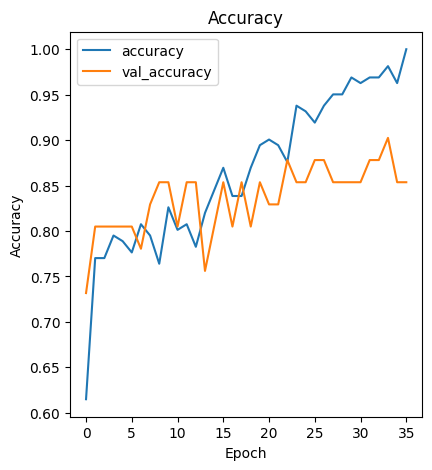

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()


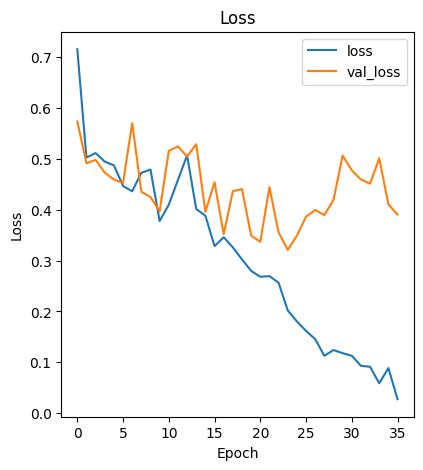

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [38]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8329 - loss: 0.6927
Test Loss: 0.6570548415184021
Test Accuracy: 0.843137264251709
